# Optimization Project 3

# MIQP vs. LASSO 
## A Comparative Analysis for Regression Variable Selection


**Group Members** 
1. Kapish Krishna Bodapati (kb45953)  
2. Bhuvana Chandrika Kothapalli (bk24542)  
3. Cate Dombrowski (cd37589)  
4. Mansi Sharma (ms89743)  
5. David Gong (dg38767)  
  

### Problem statement

In the field of predictive analytics, one of the most pervasive challenges is variable selection for regression models. Traditional methods for direct variable selection through optimization have faced significant criticism due to the formidable computational difficulties associated with evaluating all possible subsets of variables. Let's say if we have to pick the subset $k$ features from a total of $m$ features.

The total number of models that can be picked are:

$${m \choose 0} + {m \choose 1} + ... + {m\choose m} = 2^m$$


As a response to this computational challenge, techniques like LASSO (Least Absolute Shrinkage and Selection Operator) and ridge regression were developed. These methods introduce regularization terms to control the inclusion of variables in the model.

However, recent advancements in optimization software have transformed the landscape, particularly in the domain of solving mixed integer quadratic programs (MIQP). This project takes on the variable selection problem for regression and formulates it as an MIQP.

The key objective of this project is to compare the results obtained from the MIQP-based variable selection with those of LASSO. This comparison aims to assess whether the additional 'shrinkage' component provided by LASSO offers substantial benefits in terms of predictive accuracy and model interpretability, as compared to the process of identifying the 'best' set of variables for inclusion in regression models. Through this comparative analysis, we seek to gain insights into the efficacy of these variable selection techniques and their implications for predictive analytics.

In [1]:
T = 3600 # one hour Time limit for gurobi

In [2]:
# Importing the required libraries
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import gurobipy as gp
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import seaborn as sns

To compare the results of MIQP and LASSO, we use two datasets - train and test. We will fit the model using train dataset and test the model performance on test dataset.

In [3]:
# Reading the training data
train_data = pd.read_csv('training_data.csv')
train_data.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


In [4]:
# Reading the test data
test_data = pd.read_csv('test_data.csv')
test_data.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,7.107949,-2.047008,0.260132,-0.785152,0.384576,-0.137613,-0.364566,-1.941253,-0.108180,-0.339223,...,-0.522194,1.861897,0.124511,1.144071,0.128179,-0.467972,-1.085601,0.659670,0.514719,0.806656
1,5.796272,-1.354328,-1.289884,1.321533,-0.091165,-1.021874,0.686778,0.089737,-0.398371,-0.261740,...,-0.502578,0.584476,0.680703,0.046788,0.569681,-1.099062,-0.069656,0.709273,-0.848665,0.996168
2,1.598651,0.502205,1.062887,1.460733,-1.506403,0.721664,0.528921,-0.699541,-0.270331,-2.544812,...,-0.125195,-1.292924,0.411785,-0.164210,-2.407403,-1.132500,0.452923,-0.945541,0.126523,-0.972075
3,2.532953,0.222381,-0.960747,-0.113762,1.935927,0.969387,-1.641403,0.026647,0.747138,-1.571784,...,-0.546915,-0.192517,0.603420,-0.277331,-1.451419,0.220775,0.474954,-0.160109,0.188047,-1.711229
4,0.590685,1.209949,1.586874,-0.694784,-0.226370,-0.152108,0.772356,-0.573741,-0.992492,-0.646661,...,-0.982236,-1.407777,0.094211,0.159960,-0.901612,-1.653122,0.393518,0.702539,0.552663,-0.773646


Since the goal is to compare the MIQP and LASSO approaches to select the variables, it is better to scale the data first before diving further into fitting the models.

### MIQP Approach:

Given a dataset of $m$ independent variables, $X$, and a dependent variable, $y$, the standard ordinary least squares problem is formulated as

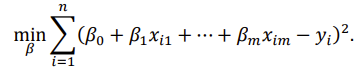

In order to incorporate variable selection into this problem we can include some binary variables, $z_j$, that force the corresponding values of $𝛽_𝑗$ to be zero if $z_j$ is zero, using the big-M method. If we only want to include at most $k$ variables from $X$, then we can pose this as

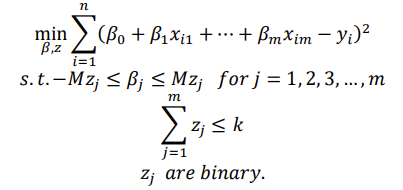

Note that we don’t ever forbid the model from having an intercept term, $𝛽_0$, and that m and M are different things here. Here, $k$ can be viewed as a hyperparameter to be chosen using cross validation.

In [5]:
m = len(train_data.columns)-1 # No. of independent variables
n = len(train_data) # No. of rows or data points

In [6]:
M = 25 # This is decided on trial and error basis after checking the beta values for k = 5

#### Splitting the training data into 10 splits to do 10 fold cross validation

In [7]:
k_fold = 10

In [8]:
# Defining a dummy variable to store the index of the train_data
p = [i for i in range(n)]
size = len(p)//k_fold

splits = [np.random.choice(p, size, replace=False) for _ in range(k_fold)]
splits

[array([222,  64, 157, 225, 177, 248, 126,  60, 156,  42, 237, 147, 234,
        120, 119, 203, 231,  34,  33, 123,   9,  15, 143, 172,  59]),
 array([161,  98, 111,  41, 147, 119,  51,   8,  26,  66, 122,  67,  55,
        175, 108, 138, 164, 132, 173, 248, 228, 176,  86,  34, 192]),
 array([136,  73, 118, 216, 140, 177, 134,  71, 167, 204,  36, 154, 235,
        109, 133, 239, 116, 172, 240, 139, 150, 125,  41,  40, 145]),
 array([161,  25, 234, 201, 172, 160,  53, 232,  48,  68,   2, 247, 214,
        184, 193, 105, 150,  50,  39,  52,  82,  46,  33, 228,  30]),
 array([111, 126, 231, 207,  84, 164, 165,  67,  76, 110,  17,  96, 242,
        161,  37,  95, 230, 163, 211, 105, 148, 174, 205, 244, 238]),
 array([167, 177,  85,   9,  39,  20,  19, 237,  32, 225, 222, 238, 213,
        178, 214,  40, 229,  21, 206, 184, 172, 231, 194,   2,  22]),
 array([100, 154, 104,  15, 158,  68, 211, 108, 153,   3,  93, 145,  75,
        159,  78,  17, 224,  62, 198, 241, 240, 132,  44,  27, 155]),

In [9]:
K = [i for i in range(5,m+1,5)] # Defining a list to store the number of different subsets to be selected

In [10]:
# Defining an empty dataframe to store the beta values for each combination of k and hold_out set
beta_values = pd.DataFrame(0, index = range(10*len(K)), columns = ['beta'+str(i) for i in range(m+1)])
beta_values['K'] = 0 # the value of k 
beta_values['cross_val'] = 0 # This represents the index of the hold_out set 
beta_values['train_error'] = 0 # Training error obtained in each case
beta_values['validation_error'] = 0 # Validation error obtained in each case
beta_values.head()

,beta0,beta1,beta2,beta3,beta4,beta5,beta6,beta7,beta8,beta9,...,beta45,beta46,beta47,beta48,beta49,beta50,K,cross_val,train_error,validation_error
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Defining an empty list to store the Average Training Error for each k and Average Validation Error for each k.
AVG_train_error = []
AVG_hold_error = []

# Looping for each value of k in K
for k in K:
    
    # Defining an empty list to store the training error nd validation error for each fold
    train_error = []
    hold_out_error = []
    
    # Looping over the 10 folds of training data where one fold is considered as hold_out_set for each case
    for q in range(k_fold):
        
        # Defining an empty list to store all the beta values, k, index of hold_out_set, training error and validation error
        # for each case
        case = []
        hold_set_index = splits[q] # Defining the hold_out_set
        train_set_index = [i for i in p if i not in splits[q]] # Combining all other splits into training set
        train_set = train_data.loc[train_set_index].reset_index(drop=True) # Resetting the index of train_set
        hold_set = train_data.loc[hold_set_index].reset_index(drop=True) # Resetting the index of hold_set
                
        lm = gp.Model()
        beta = lm.addMVar(m+1,lb=-np.inf)
        z = lm.addMVar(m+1, vtype = 'B') # z[0] is dummy and not used in constraints or objective function

        # Defining the objective function to minimize the sum of squared errors
        lm.setObjective(gp.quicksum(
            (gp.quicksum(beta[0]+beta[j]*train_set.iloc[i,j] for j in range(1,m+1))-train_set.iloc[i,0])*
            (gp.quicksum(beta[0]+beta[j]*train_set.iloc[i,j] for j in range(1,m+1))-train_set.iloc[i,0]) 
            for i in range(len(train_set))), sense=gp.GRB.MINIMIZE)
        
        # Big-M Constraints
        lm.addConstrs(beta[i] <= M*z[i] for i in range(1,m+1))
        lm.addConstrs(beta[i] >= -M*z[i] for i in range(1,m+1))
        
        # Total number of variables to be selected is less than or equal to k
        lm.addConstr(gp.quicksum(z[i] for i in range(1,m+1))<=k)
        
        lm.Params.OutputFlag = 0 # tell gurobi to shut up!!
        lm.Params.TimeLimit = T # Setting the time limit of each model to one hour
        lm.optimize()
        
        betas = beta.x 
        case.extend(betas) # Getting the values of betas and storing them in 'case' list
        case.append(k) # storing the value of 'k' in the same list
        case.append(q) # storing the index of hold_out_set in the same list
        
        training_error = lm.ObjVal/len(train_set) # Calculating the training error for each case
        train_error.append(training_error) # Storing the training error in 'train_error'
        case.append(training_error) # Storing the training error in 'case' also
        
        # Calculating the validation error for each case using the beta values obtained from the model
        hold_error = gp.quicksum((gp.quicksum(betas[0]+betas[j]*hold_set.iloc[i,j] for j in range(1,m+1))-hold_set.iloc[i,0])*
                                 (gp.quicksum(betas[0]+betas[j]*hold_set.iloc[i,j] for j in range(1,m+1))-hold_set.iloc[i,0]) 
                                 for i in range(len(hold_set))) 
        
        hold_error = hold_error.getValue()/len(hold_set)
        hold_out_error.append(hold_error) # Storing the validation error in 'hold_out_error'
        case.append(hold_error) # Storing the validation error in 'case' also
        
        row = K.index(k)*k_fold+q # calculating the row number of each case in the 'beta_values' dataframe
        beta_values.iloc[row,:] = case # Storing the values of each case in the 'beata_values' dataframe
        
    avg_train_error = np.mean(train_error) # Calculating the average training error for each value of k
    avg_hold_out_error = np.mean(hold_out_error) # Calculating the average validation error for each value of k
    
    AVG_train_error.append(avg_train_error) # Storing the average training error for each value of k in a separate list
    AVG_hold_error.append(avg_hold_out_error) # Storing the average validation error for each value of k in a separate list
    
best_hold_error = min(AVG_hold_error) # Getting the best validation error
print(best_hold_error) # printing the best validation error
best_k = K[AVG_hold_error.index(best_hold_error)] # Getting the value of k for best validation error
print(best_k) # printing the best k

# Export the results to a csv file
beta_values.to_csv('beta_values1.csv')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-21
2.6884472131022994
10


In [12]:
beta_values.head()

,beta0,beta1,beta2,beta3,beta4,beta5,beta6,beta7,beta8,beta9,...,beta45,beta46,beta47,beta48,beta49,beta50,K,cross_val,train_error,validation_error
0,0.022484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.419131,...,1.877492,0.0,0.879633,0.0,0.0,0.0,5,0,3.486969,3.500475
1,0.020369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.497276,...,1.938038,0.0,0.927044,0.0,0.0,0.0,5,1,3.620518,2.325390
2,0.022526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.434186,...,1.895095,0.0,0.864553,0.0,0.0,0.0,5,2,3.643260,2.144079
3,0.019951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.427307,...,1.917278,0.0,0.837529,0.0,0.0,0.0,5,3,3.372618,4.527128
4,0.021077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.470612,...,1.881079,0.0,0.900545,0.0,0.0,0.0,5,4,3.499089,3.360373


In [13]:
# Storing only the value of k, average_training_error and average_validation_error in a separate dataframe
error = beta_values[['K', 'train_error', 'validation_error']].groupby('K')[['train_error', 'validation_error']].agg('mean')
error

,train_error,validation_error
K,,
5,3.486874,3.509241
10,2.388034,2.688447
15,2.250168,2.890222
20,2.173727,2.964927
25,2.121602,2.816264
30,2.093488,2.961682
35,2.075596,3.001157
40,2.065325,2.998427
45,2.059800,3.017379


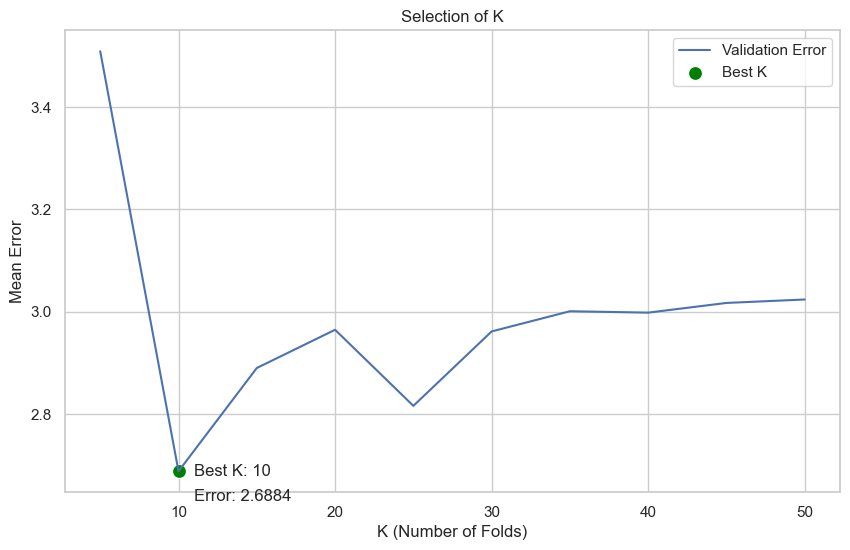

In [14]:
# Plotting the above values in a graph to see how validation error changes with the value of k

# Extracting the data
K_values = error.index
validation_errors = error['validation_error']

# Find the index of the lowest validation error
lowest_error_index = validation_errors.idxmin()
lowest_error = validation_errors.min()

# Setting the style
sns.set(style="whitegrid")

# Creating the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=K_values, y=validation_errors, label='Validation Error')

# Mark the lowest point with a different color
sns.scatterplot(x=[lowest_error_index], y=[lowest_error], color='green', s=100, label='Best K')

# Adding labels and a legend
plt.xlabel('K (Number of Folds)')
plt.ylabel('Mean Error')
plt.title('Selection of K')
plt.legend()

# Annotate the best K with an arrow on the side
plt.text(lowest_error_index + 1, lowest_error, f'Best K: {lowest_error_index}', ha='left', va='center')
plt.text(lowest_error_index + 1, lowest_error - 0.05, f'Error: {lowest_error:.4f}', ha='left', va='center')

# Modify the line to be dashed
line = plt.gca().get_lines()[0]  # Get the first line

# Display the plot
plt.show()

Validation error is lowest for k=10. Fitting a model to the entire training data for k=10.

In [15]:
# Defining another gurobi model 'lm_best' to fit using the entire training set with best k value
k = best_k
lm_best = gp.Model()
beta = lm_best.addMVar(m+1,lb=-np.inf)
z = lm_best.addMVar(m+1, vtype = 'B') # z[0] is dummy and not used in constraints or objective function

# Defining the objective function to minimize the sum of squared errors
lm_best.setObjective(gp.quicksum((beta[0]+gp.quicksum(beta[j]*train_data.iloc[i,j] for j in range(1,m+1))-train_data.iloc[i,0])*
                                 (beta[0]+gp.quicksum(beta[j]*train_data.iloc[i,j] for j in range(1,m+1))-train_data.iloc[i,0]) 
                                 for i in range(len(train_data))), sense=gp.GRB.MINIMIZE)

# Big-M Constraints
lm_best.addConstrs(beta[i] <= M*z[i] for i in range(1,m+1))
lm_best.addConstrs(beta[i] >= -M*z[i] for i in range(1,m+1))

# Total number of variables to be selected is less than or equal to k
lm_best.addConstr(gp.quicksum(z[i] for i in range(1,m+1))<=k)

lm_best.Params.OutputFlag = 0 # tell gurobi to shut up!!
lm_best.Params.TimeLimit = T
lm_best.optimize()

# Calculate the training error (Mean Squared Error)
best_train_error = lm_best.ObjVal/len(train_data)

# Calculate the test error (Mean Squared Error)
# Now, apply the model to the test data to calculate the predictions
test_predictions = []
for i in range(test_data.shape[0]):
    best_beta = beta.x
    test_predictions.append(best_beta[0] + sum(best_beta[j] * test_data.iloc[i, j] for j in range(1, m + 1)))

test_error = np.mean((np.array(test_predictions) - test_data.iloc[:, 0]) ** 2)

print("MIQP Training Mean Squared Error:", best_train_error)
print("MIQP Test Mean Squared Error:", test_error)

print(best_beta)

MIQP Training Mean Squared Error: 2.3919852662914747
MIQP Test Mean Squared Error: 2.3365439645525248
[ 0.97252408  0.          0.          0.          0.          0.
  0.          0.          0.         -2.30820726  0.          0.
  0.          0.          0.         -0.51832612 -0.20416201  0.
  0.          0.          0.          0.          0.         -1.55914318
  0.86697336  0.         -1.31191942  0.          0.          0.
  0.          0.          0.          0.          0.4081653   0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.78147489  0.          0.88738292
 -0.28229213  0.          0.        ]


In [16]:
beta_index = [list(best_beta).index(i) for i in best_beta if i!=0]
beta_index

[0, 9, 15, 16, 23, 24, 26, 34, 45, 47, 48]

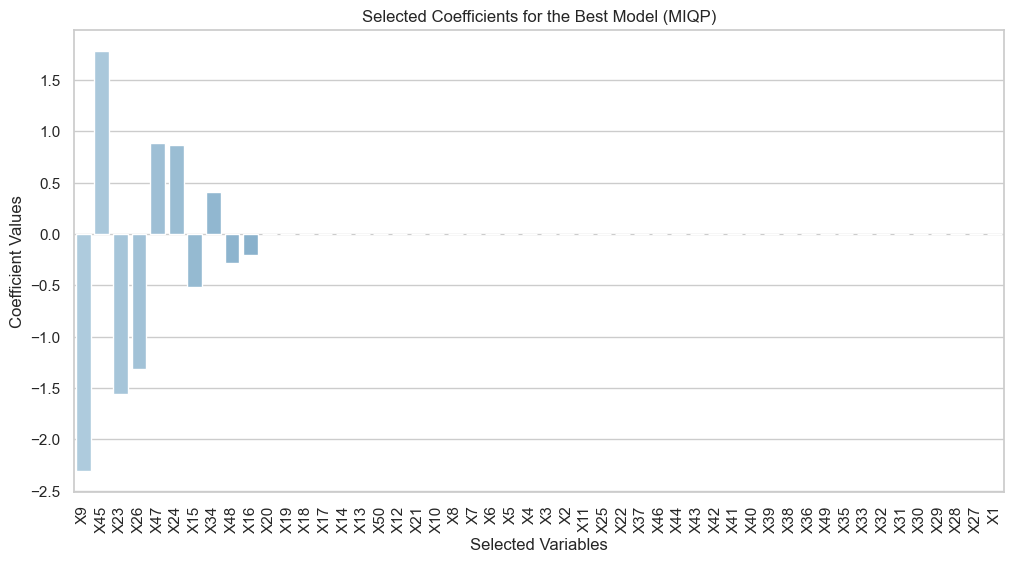

In [17]:
# Extract the best coefficients from the model
best_beta_ = best_beta[1:]  # Exclude the intercept

# Get the names of the selected variables
selected_variable_names = train_data.columns[1:]

# Sort the coefficients and variable names by magnitude (absolute value)
sorted_indices = np.argsort(np.abs(best_beta_))[::-1]  # Sort in descending order

# Sort the variable names and coefficients based on the sorted indices
sorted_variable_names = [selected_variable_names[i] for i in sorted_indices]
sorted_coefficients = [best_beta_[i] for i in sorted_indices]

# Create a Seaborn bar plot for the sorted coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_variable_names, y=sorted_coefficients, palette="Blues_d")
plt.xlabel('Selected Variables')
plt.ylabel('Coefficient Values')
plt.title('Selected Coefficients for the Best Model (MIQP)')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

### Lasso Model

In LASSO (Least Absolute Shrinkage and Selection Operator), variable selection is performed by solving the following optimization problem:

$$\boxed{y_{predicted} = min_{\beta}(\Sigma^{n}_{i=1}(\beta_{0}+\beta_{1}x_{i1}+...+\beta_{m}x_{im}-y_i)^{2} + \lambda\Sigma_{j=1}^{m}|\beta_{j}|)}$$

In this equation, the term $\lambda$ plays a critical role in determining the level of penalty applied to the cost function. When $\lambda$ is large, it strongly penalizes the model, driving some of the coefficients ($\beta_j$) to become exactly 0. It's important to note that the intercept term $\beta_0$ is not included in the penalty term. As $\lambda$ becomes very large, the regression prediction effectively reduces to the mean of the target variables.

In [18]:
# Seperating the independent and dependent variables in both train and test datasets
train_X = train_data.drop(['y'], axis = 1)
train_Y = train_data['y'] 
test_X = test_data.drop(['y'], axis = 1)
test_Y = test_data['y']

# Scaling the independent variables using StandardScaler from sklearn.preprocessing.
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [19]:
n_folds = 10

# Use KFold for cross-validation
k_fold = KFold(n_splits=n_folds, shuffle=True, random_state=5)
alphas = 10**np.linspace(-3, 1, 100)

lasso_avg_mse = {}
lasso_non_zero_vars = {}

# For each value of alpha and each fold, compute the mean squared error and non-zero variables
for alpha in alphas:
    
    # Instantiate a lasso model with the current alpha
    lasso = linear_model.Lasso(alpha=alpha, random_state=5, max_iter=10000)
    avg_mse = 0
    non_zero_vars = 0

    for k, (train, test) in enumerate(k_fold.split(train_X, train_Y)):
        # Use iloc to access specific rows for training
        lasso.fit(train_X.iloc[train], train_Y.iloc[train])

        # Calculate the average mean squared error
        avg_mse += np.mean((lasso.predict(train_X.iloc[test]) - train_Y.iloc[test])**2)

        # Count the number of non-zero coefficients
        non_zero_vars += np.sum(lasso.coef_ != 0)

    # Take the average mean squared error as a metric
    lasso_avg_mse[alpha] = avg_mse / n_folds
    # Take the average number of non-zero variables
    lasso_non_zero_vars[alpha] = non_zero_vars / n_folds

# Find the best value for alpha with minimum mean squared error
best_alpha_lasso = min(lasso_avg_mse, key=lasso_avg_mse.get)
print("Best lasso alpha: {}".format(best_alpha_lasso))

Best lasso alpha: 0.07924828983539177


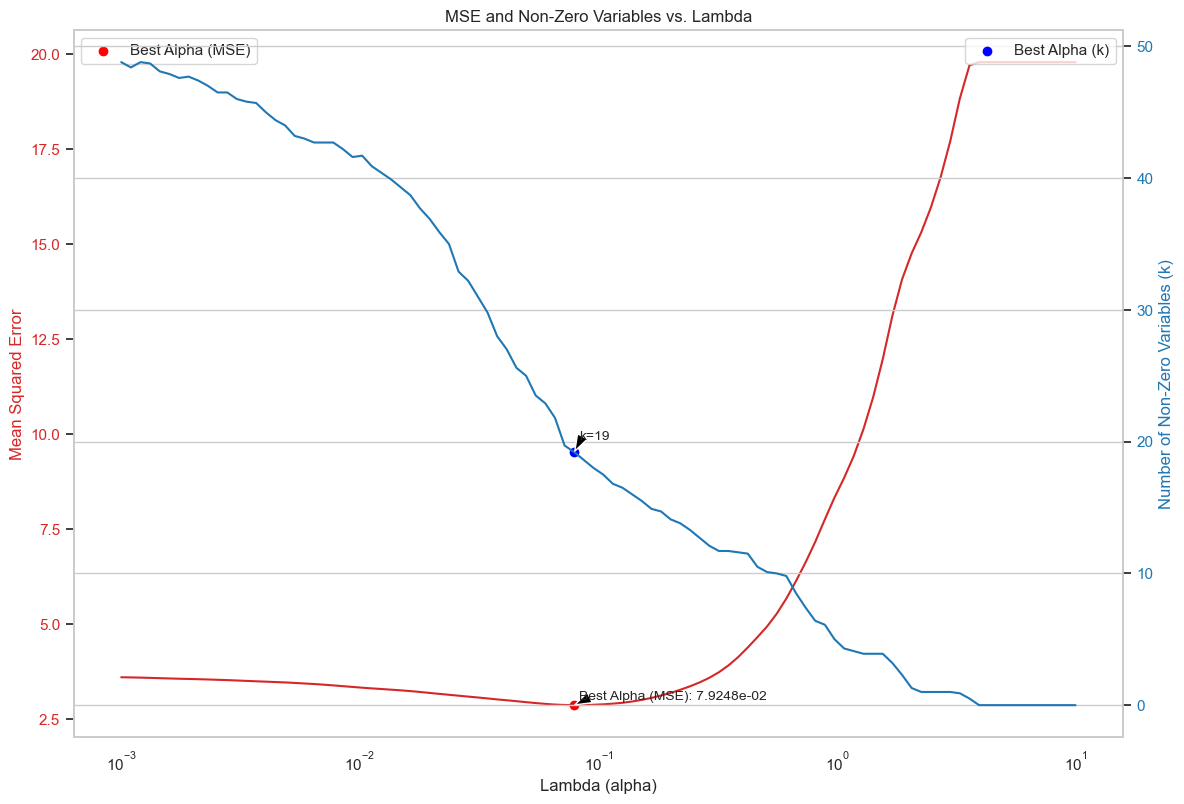

In [20]:
# Plotting the results with adjusted settings
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:red'
ax1.set_xlabel('Lambda (alpha)')
ax1.set_xscale('log')  # Use log scale for better visualization
ax1.set_ylabel('Mean Squared Error', color=color)
ax1.plot(list(lasso_avg_mse.keys()), list(lasso_avg_mse.values()), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False)  # Remove grid lines

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Number of Non-Zero Variables (k)', color=color)  
ax2.plot(list(lasso_non_zero_vars.keys()), list(lasso_non_zero_vars.values()), color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Mark the point for the best lambda with k
ax1.scatter(best_alpha_lasso, lasso_avg_mse[best_alpha_lasso], color='red', label='Best Alpha (MSE)')
ax2.scatter(best_alpha_lasso, lasso_non_zero_vars[best_alpha_lasso], color='blue', label='Best Alpha (k)')

# Add annotations for k and best lambda with adjusted arrow size
ax2.annotate(f'k={int(lasso_non_zero_vars[best_alpha_lasso])}', xy=(best_alpha_lasso, lasso_non_zero_vars[best_alpha_lasso]), xytext=(best_alpha_lasso*1.05, lasso_non_zero_vars[best_alpha_lasso]*1.05),
             arrowprops=dict(facecolor='black', shrink=0.1, width=0.5, headwidth=8), fontsize=10)
ax1.annotate(f'Best Alpha (MSE): {best_alpha_lasso:.4e}', xy=(best_alpha_lasso, lasso_avg_mse[best_alpha_lasso]), xytext=(best_alpha_lasso*1.05, lasso_avg_mse[best_alpha_lasso]*1.05),
             arrowprops=dict(facecolor='black', shrink=0.1, width=0.5, headwidth=8), fontsize=10)

# Display legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()  
plt.title('MSE and Non-Zero Variables vs. Lambda')
plt.show()

In [21]:
# Creating the Lasso model
lasso_model = linear_model.Lasso(alpha=best_alpha_lasso, random_state = 5, max_iter = 100000)
lasso_model.fit(train_X, train_Y)


# Getting the predictions and mean squared error
lasso_predictions = lasso_model.predict(test_X)
lasso_mse = mean_squared_error(test_Y, lasso_predictions)
print("Lasso Mean Squared Error:", lasso_mse)

# Getting the coefficients of the Lasso model
lasso_intercept = lasso_model.intercept_
#print("Lasso Intercept:", lasso_intercept)

lasso_coefficients = lasso_model.coef_
#print("Lasso Coefficients:", lasso_coefficients)

# Count the number of selected variables (non-zero coefficients)
num_selected_variables = np.sum(lasso_coefficients != 0)
print("Number of Selected Variables:", num_selected_variables)

lasso_betas = [lasso_intercept] + list(lasso_coefficients)
print(lasso_betas)

Lasso Mean Squared Error: 2.3507076294746323
Number of Selected Variables: 18
[1.0026907640106222, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -2.157072715398916, 0.0, -0.05695214747603138, -0.0, -0.0, -0.0, -0.4183487973254796, -0.19286371302018898, 0.0, 0.0, -0.0, 0.0, 0.0, -0.19557637808204317, -1.361735500972083, 0.7400796534973794, -0.0, -1.304040319615434, -0.0, 0.0, 0.05885991984279234, 0.0, -0.0, 0.0, -0.09667404974365869, 0.27916430919441915, 0.00011433542509450695, 0.0, 0.0, 0.0, -0.22740501693446494, 0.0, -0.0, 0.0, 0.0, 0.027714511974681232, 1.5606909774215438, -0.018349580155387117, 0.6944557887805629, -0.09125228126921665, 0.0, 0.0]


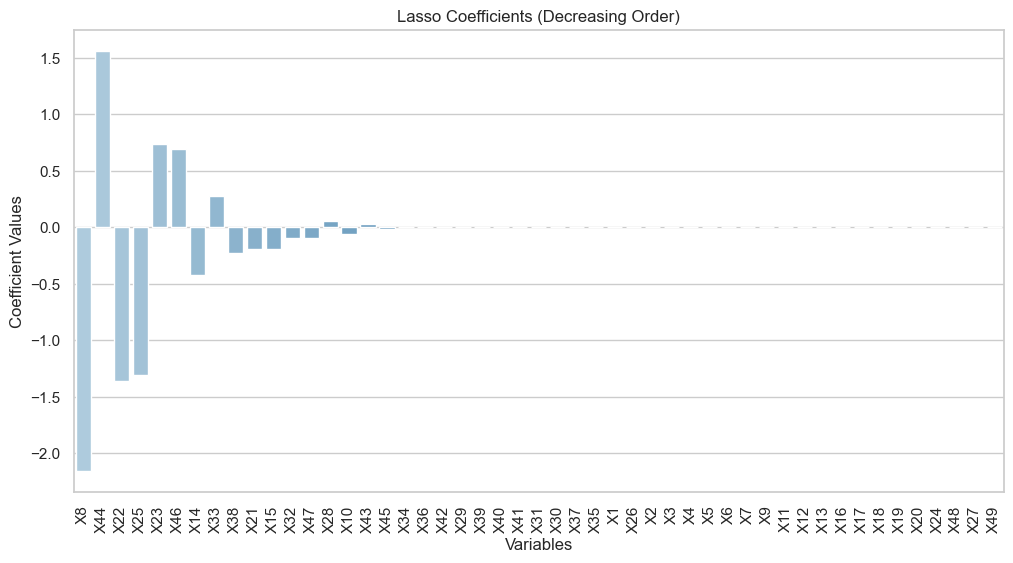

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the coefficients from the Lasso model
lasso_coefficients = lasso_coefficients[1:]  # Exclude the intercept

# Get the names of the variables
variable_names = train_X.columns

# Sort the coefficients and variable names in decreasing order of absolute magnitude
sorted_indices = (-np.abs(lasso_coefficients)).argsort()  # Sort in descending order

# Sort the variable names and coefficients based on the sorted indices
sorted_variable_names = [variable_names[i] for i in sorted_indices]
sorted_coefficients = [lasso_coefficients[i] for i in sorted_indices]

# Create a Seaborn bar plot for the sorted coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_variable_names, y=sorted_coefficients, palette="Blues_d")
plt.xlabel('Variables')
plt.ylabel('Coefficient Values')
plt.title('Lasso Coefficients (Decreasing Order)')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()


In [23]:
lasso_beta_index = [list(lasso_betas).index(i) for i in lasso_betas if i!=0]
lasso_beta_index

[0, 9, 11, 15, 16, 22, 23, 24, 26, 29, 33, 34, 35, 39, 44, 45, 46, 47, 48]

## Comparision

In [60]:
selected_variables_miqp = [i for i in range(1, m+1) if z[i].x == 1]
selected_variables_lasso = [i for i, coef in enumerate(lasso_coefficients) if coef != 0]

common_selected_variables = set(selected_variables_miqp).intersection(selected_variables_lasso)
unique_miqp_variables = set(selected_variables_miqp).difference(selected_variables_lasso)
unique_lasso_variables = set(selected_variables_lasso).difference(selected_variables_miqp)

print("Common Selected Variables:", common_selected_variables)
print("Variables Unique to MIQP Model:", unique_miqp_variables)
print("Variables Unique to Lasso Model:", unique_lasso_variables)

Common Selected Variables: {26, 45, 23}
Variables Unique to MIQP Model: {34, 9, 15, 16, 47, 48, 24}
Variables Unique to Lasso Model: {6, 8, 12, 13, 19, 20, 21, 30, 31, 32, 36, 41, 42, 43, 44}


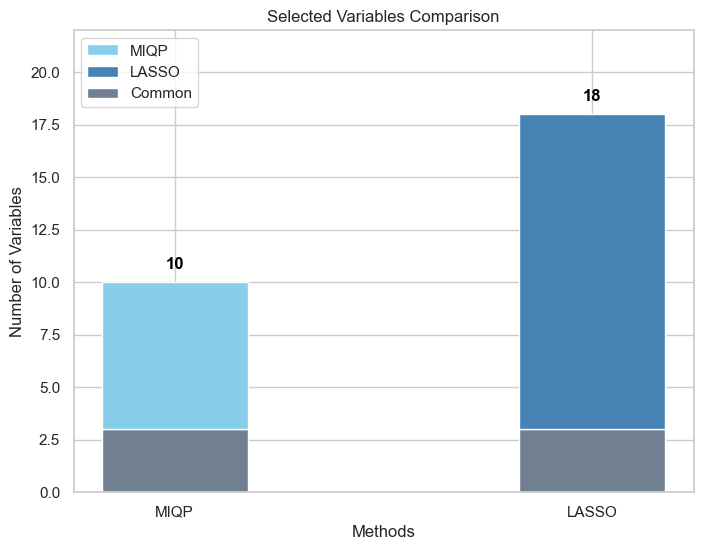

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
methods = ['MIQP', 'LASSO']
miqp_count = len(selected_variables_miqp)
lasso_count = len(selected_variables_lasso)
common_range = len(common_selected_variables)

# Plotting the bar chart
bar_width = 0.35
index = np.arange(len(methods))

plt.figure(figsize=(8, 6))

# Plot the common range in the same color for both methods (lower part)
common_bar = plt.bar(index, [common_range, common_range], bar_width, color='slategrey', label='Common')

# Plot the unique variables in different colors for each method (upper part)
miqp_bar = plt.bar(index, [miqp_count - common_range, lasso_count - common_range], bar_width, bottom=[common_range, common_range], color=['skyblue', 'steelblue'], label=['MIQP', 'LASSO'])

# Labeling and styling
plt.title('Selected Variables Comparison')
plt.xlabel('Methods')
plt.ylabel('Number of Variables')
plt.xticks(index, methods)

# Set y-axis limit to 22
plt.ylim(0, 22)

# Add data labels on top of each stack
for i, value in enumerate([miqp_count, lasso_count]):
    plt.text(index[i], value + 0.5, str(value), ha='center', va='bottom', color='black', fontweight='bold')

# Adjust legend to the best location
plt.legend(loc='upper left')

# Display the plot
plt.show()


In [25]:
from sklearn.metrics import mean_squared_error

# Calculate MIQP predictions
miqp_predictions = np.dot(test_X, best_beta[1:]) + best_beta[0]

# Calculate MIQP MSE
miqp_mse = mean_squared_error(test_Y, miqp_predictions)
print("MIQP Mean Squared Error:", miqp_mse)
print("LASSO Mean Squared Error:", lasso_mse)

# Now, you have both MIQP and LASSO MSE, and you can compare them
if miqp_mse < lasso_mse:
    print("MIQP has a lower Mean Squared Error, indicating better performance.")
elif lasso_mse < miqp_mse:
    print("LASSO has a lower Mean Squared Error, indicating better performance.")
else:
    print("Both MIQP and LASSO have the same Mean Squared Error.")


MIQP Mean Squared Error: 2.336543964552525
LASSO Mean Squared Error: 2.3507076294746323
MIQP has a lower Mean Squared Error, indicating better performance.


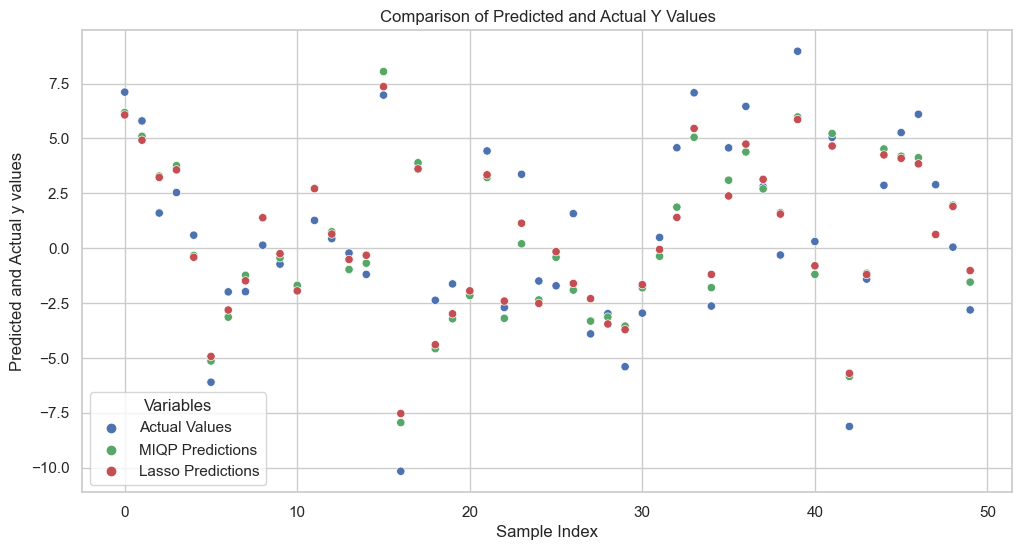

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
sample_index = range(len(test_Y))
actual_values = test_Y
miqp_predictions = test_predictions
lasso_predictions = lasso_predictions

# Create a DataFrame
data = {
    'Sample Index': sample_index,
    'Actual Values': actual_values,
    'MIQP Predictions': miqp_predictions,
    'Lasso Predictions': lasso_predictions,
}
df = pd.DataFrame(data)

# Melt the DataFrame for Seaborn
df_melted = pd.melt(df, id_vars=['Sample Index'], value_vars=['Actual Values', 'MIQP Predictions', 'Lasso Predictions'])

# Create the Seaborn line plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.scatterplot(x='Sample Index', y='value', hue='variable', data=df_melted, palette=['b', 'g', 'r'])
plt.xlabel('Sample Index')
plt.ylabel('Predicted and Actual y values')
plt.title("Comparison of Predicted and Actual Y Values")
plt.legend(title='Variables')
plt.show()

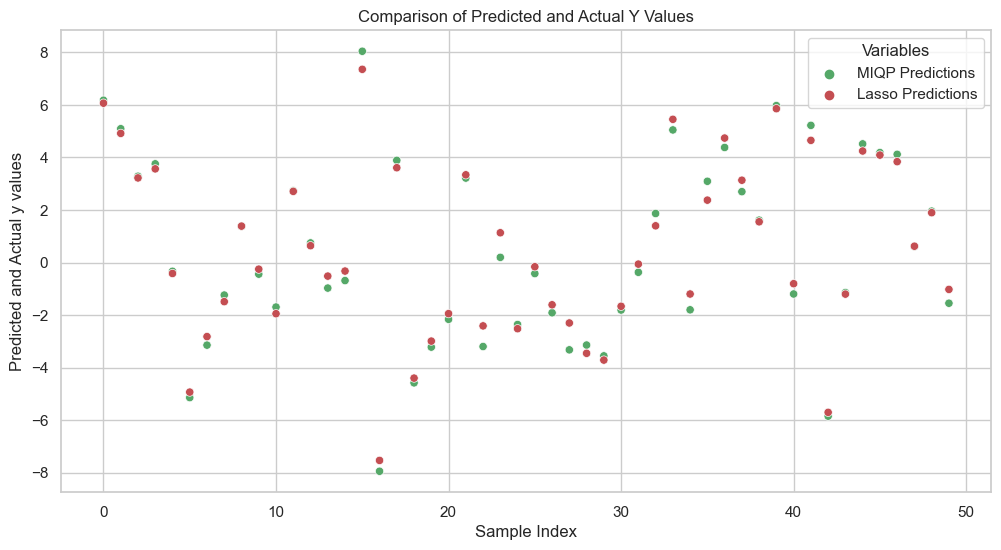

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
sample_index = range(len(test_Y))
actual_values = test_Y
miqp_predictions = test_predictions
lasso_predictions = lasso_predictions

# Create a DataFrame
data = {
    'Sample Index': sample_index,
    'MIQP Predictions': miqp_predictions,
    'Lasso Predictions': lasso_predictions,
}
df = pd.DataFrame(data)

# Melt the DataFrame for Seaborn
df_melted = pd.melt(df, id_vars=['Sample Index'], value_vars=['MIQP Predictions', 'Lasso Predictions'])

# Create the Seaborn line plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.scatterplot(x='Sample Index', y='value', hue='variable', data=df_melted, palette=['g', 'r'])
plt.xlabel('Sample Index')
plt.ylabel('Predicted and Actual y values')
plt.title("Comparison of Predicted and Actual Y Values")
plt.legend(title='Variables')
plt.show()

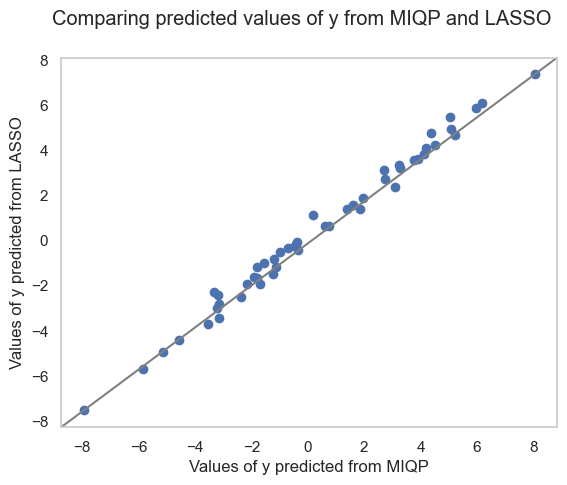

In [28]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.scatter(miqp_predictions, lasso_predictions)
fig.suptitle('Comparing predicted values of y from MIQP and LASSO')
ax.set_xlabel('Values of y predicted from MIQP')
ax.set_ylabel('Values of y predicted from LASSO')

# Reference line
line = mlines.Line2D([0, 1], [0, 1], color='grey')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.grid()

plt.show()

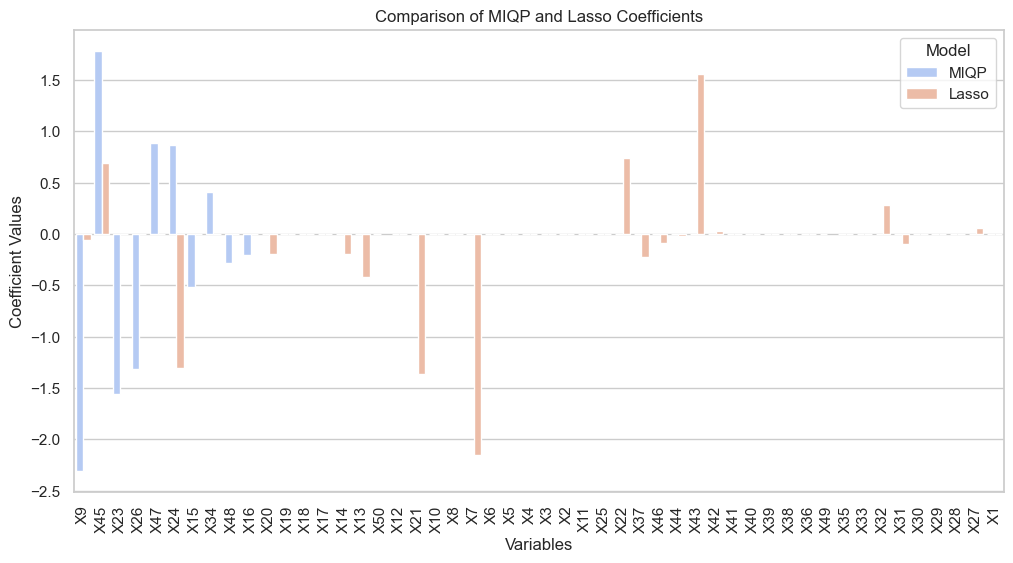

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plotting MIQP coefficients
best_beta = best_beta[1:]  # Exclude the intercept
selected_variable_names = train_data.columns[1:]

# Sort MIQP coefficients by magnitude (absolute value)
sorted_indices_miqp = np.argsort(np.abs(best_beta))[::-1]

# Sort the variable names and coefficients based on the sorted indices
sorted_variable_names_miqp = [selected_variable_names[i] for i in sorted_indices_miqp]
sorted_coefficients_miqp = [best_beta[i] for i in sorted_indices_miqp]

# Plotting Lasso coefficients
lasso_coefficients = lasso_coefficients[1:]  # Exclude the intercept
variable_names = train_X.columns

# Sort Lasso coefficients by magnitude (absolute value)
sorted_indices_lasso = (-np.abs(lasso_coefficients)).argsort()

# Sort the variable names and coefficients based on the sorted indices
sorted_variable_names_lasso = [variable_names[i] for i in sorted_indices_lasso]
sorted_coefficients_lasso = [lasso_coefficients[i] for i in sorted_indices_lasso]

# Combine the sorted coefficients and variable names
combined_variable_names = sorted_variable_names_miqp + sorted_variable_names_lasso
combined_coefficients = sorted_coefficients_miqp + sorted_coefficients_lasso

# Create labels to distinguish between MIQP and Lasso coefficients
labels = (['MIQP'] * len(sorted_variable_names_miqp)) + (['Lasso'] * len(sorted_variable_names_lasso))

# Create a Seaborn bar plot for the combined coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x=combined_variable_names, y=combined_coefficients, hue=labels, palette="coolwarm")
plt.xlabel('Variables')
plt.ylabel('Coefficient Values')
plt.title('Comparison of MIQP and Lasso Coefficients')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.legend(title='Model')
plt.show()

From the above plot we can see that MIQP is zeroing out most of the variables when compared to LASSO. MIQP is the preferred choice when precise subset selection is critical as it excels at exactly zeroing out unnecessary variables, making it ideal for situations where you have specific constraints or requirements on the inclusion or exclusion of certain features. But when subset selection is not that critical then LASSO is the best choice as it offers the advantage of computational efficiency. 